In [29]:
# import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import OneHotEncoder, StandardScaler, Normalizer, LabelEncoder, MinMaxScaler

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from imblearn.over_sampling import SMOTE
from scipy.stats import boxcox
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.metrics import roc_auc_score

import warnings
warnings.filterwarnings('ignore')
warnings.filterwarnings("ignore", message="numpy.ufunc size changed")
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

In [3]:
# importing clean data

data = pd.read_csv('C:/Users/ivanr/Downloads/clean_creditcardmarketing.csv')
data.head()

,Unnamed: 0,offer_accepted,reward,mailer_type,income_level,bank_accounts_open,overdraft_protection,credit_rating,credit_cards_held,homes_owned,household_size,own_your_home,average_balance,q1_balance,q2_balance,q3_balance,q4_balance
0,0,No,Air Miles,Letter,High,1,No,High,2,1,4,No,1160.75,1669.0,877.0,1095.0,1002.0
1,1,No,Air Miles,Letter,Medium,1,No,Medium,2,2,5,Yes,147.25,39.0,106.0,78.0,366.0
2,2,No,Air Miles,Postcard,High,2,No,Medium,2,1,2,Yes,276.50,367.0,352.0,145.0,242.0
3,3,No,Air Miles,Letter,Medium,2,No,High,1,1,4,No,1219.00,1578.0,1760.0,1119.0,419.0
4,4,No,Air Miles,Letter,Medium,1,No,Medium,2,1,6,Yes,1211.00,2140.0,1357.0,982.0,365.0


In [4]:
# drop index column
data = data.drop(['Unnamed: 0'], axis = 1)
data.columns

Index(['offer_accepted', 'reward', 'mailer_type', 'income_level',
       'bank_accounts_open', 'overdraft_protection', 'credit_rating',
       'credit_cards_held', 'homes_owned', 'household_size', 'own_your_home',
       'average_balance', 'q1_balance', 'q2_balance', 'q3_balance',
       'q4_balance'],
      dtype='object')

## Modelling

#### Removing outliers

In [5]:
## define a function to remove outliers on continuos data
def remove_outliers(df, threshold=1.7):
    numerical = df.select_dtypes(np.number)
    columns = numerical.columns
    for column in columns:
        if len(df[column].unique()) < 100:
            continue
        else:
            upper = np.percentile(df[column], 75)
            lower = np.percentile(df[column], 25)
            iqr = upper - lower
            upper_limit = upper + threshold * iqr
            lower_limit = lower - threshold * iqr
            df = df[(df[column]>lower_limit) & (df[column]<upper_limit)]
    return df

In [6]:
data = remove_outliers(data)

In [7]:
data = data.reset_index(drop=True)

In [8]:
data.shape

(17516, 16)

After testing threshold for finding IQR i decide to go with a 1.7 

#### Transforming

First, we will check distribution of continuous and decide do we need transformation for any of them.

In [9]:
# extracting all balance columns to plot them  
balance_cols = data.iloc[:, -5:]

average_balance


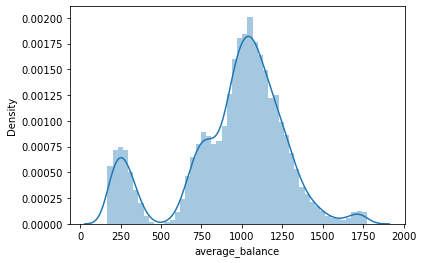

q1_balance


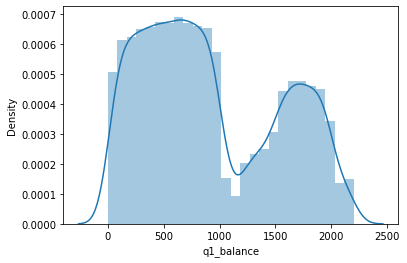

q2_balance


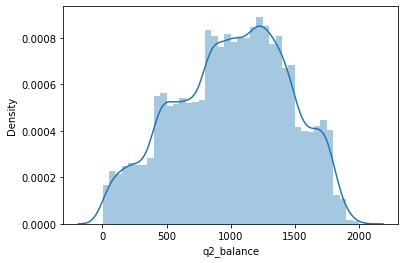

q3_balance


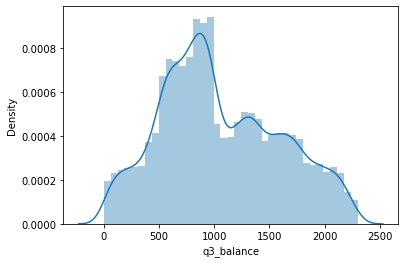

q4_balance


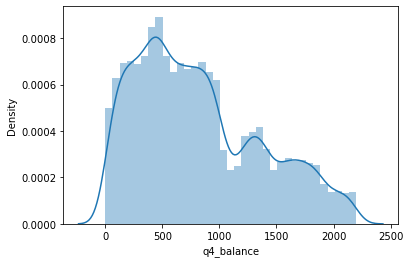

In [10]:
# checking for distribution
for numerical_col in balance_cols.columns:
    print(numerical_col)
    sns.distplot(data[numerical_col])
    plt.show()

We note that the average, Q2 & Q3 balances have relatively normal distributions, whereas the Q1 & Q4 balances generally tend to be on the lower side

Now we will analize and try different transformation on each column:

In [11]:
#define function
def log_transform(x):
    if x<=0:
        return 0
    else:
        return np.log(x)

In [12]:
# square root transformation
def sq_rt_transform(x):
    if x<0:
        return 0
    else:
        return x**0.5

In [13]:
# cube root transformation
def cube_rt_transform(x):
    if x<0:
        return 0
    else:
        return x**0.333

<AxesSubplot:ylabel='Density'>

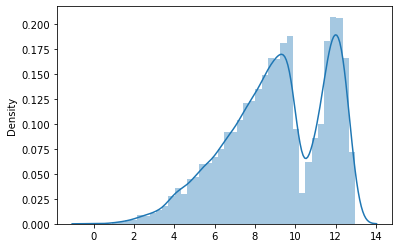

In [14]:
temp = list(map(cube_rt_transform, data['q1_balance']))
sns.distplot(temp)

In [15]:
temp = boxcox(data['q1_balance'])[0]
sns.distplot(temp)

ValueError: Data must be positive.

In [16]:
min(data['q1_balance'])

0.0

Since we have zero values in column we cannot do boxcox transformation.
We will try to define function to fill zero values with smallest posibble positive number in column and then try to transform data.

In [17]:
def fill_zeros(df, column_name):
    smallest_positive = df[df[column_name] > 0][column_name].min()
    df[column_name] = df[column_name].replace(0, smallest_positive)

In [18]:
fill_zeros(data, 'q1_balance')

In [19]:
min(data['q1_balance'])

1.0

<AxesSubplot:ylabel='Density'>

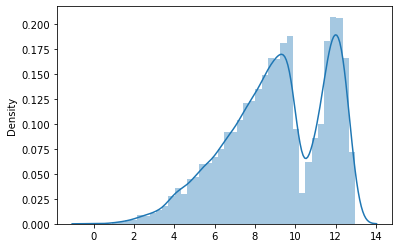

In [20]:
temp_bc = boxcox(data['q1_balance'])[0]
sns.distplot(temp)

<AxesSubplot:ylabel='Density'>

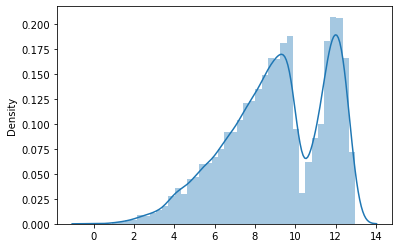

In [21]:
temp_sqrt = list(map(sq_rt_transform, data['q1_balance']))
sns.distplot(temp)

After trying different transformations on q1 balance we decided to go with square root. 

In [22]:
data['q1_balance'] = list(map(sq_rt_transform, data['q1_balance']))

<AxesSubplot:ylabel='Density'>

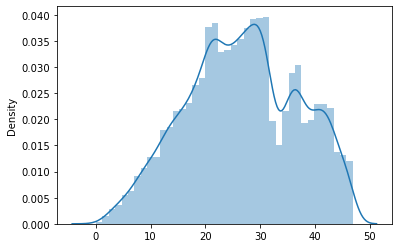

In [23]:
temp = list(map(sq_rt_transform, data['q4_balance']))
sns.distplot(temp)

<AxesSubplot:ylabel='Density'>

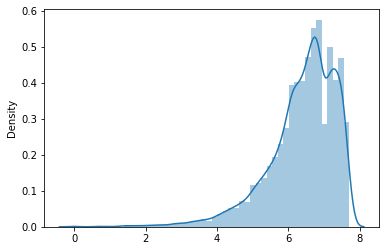

In [24]:
temp = list(map(log_transform, data['q4_balance']))
sns.distplot(temp)

Square root transformation looks good on q4_balance so we will apply it to data.

In [25]:
data['q4_balance'] = list(map(sq_rt_transform, data['q4_balance']))

## Scaling and Encoding

In [26]:
def normalize_data(df):
    num = df.select_dtypes(np.number)
    transformer = MinMaxScaler().fit(num) 
    x_minmax = transformer.transform(num)
    num_norm = pd.DataFrame(x_minmax, columns=num.columns, index=num.index)
    return num_norm

In [27]:
def encode_cat(df, target):
    cat = df.select_dtypes(object)
    y = cat[target]
    cat.drop(target, axis=1, inplace=True)
    cat = pd.get_dummies(cat, columns=cat.columns, drop_first=True)
    cat = pd.concat([cat, y], axis=1)
    return cat

Scaling, encoding and concatenate data excluding q balances

In [30]:
data_1 = data.copy()

# 1. drop quarterly balances
to_drop = ['q1_balance', 'q2_balance', 'q3_balance', 'q4_balance']
data_1.drop(to_drop, axis=1)

# 2. scale numerical data
num_norm_1 = normalize_data(data_1)

# 3. encode categorical data
cat_1 = encode_cat(data_1, 'offer_accepted')

# 4. concat 
data_nq = pd.concat([num_norm_1, cat_1], axis = 1)


Define evaluating functions

In [31]:
def evaluate_model(df, target, model, balance=None):
    y = df[target]
    X = df.drop(target, axis=1)
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=8)
    
    if balance == 'smote':
        smote = SMOTE()
        X_train, y_train = smote.fit_resample(X_train, y_train)
    
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    
    acc = accuracy_score(y_test, y_pred)
    cm = confusion_matrix(y_test, y_pred, labels=["No", "Yes"])
    sns.heatmap(cm, annot=True, fmt='g', xticklabels=["No", "Yes"], yticklabels=["No", "Yes"])
    rejected_offers = round(cm[0][0] * 100 / sum(cm[0]), 2)
    print("Rejected offers prediction accuracy:", rejected_offers, "%")
    accepted_offers = round(cm[1][1] * 100 / sum(cm[1]), 2)  
    print("Accepted offers prediction accuracy:", accepted_offers, "%")

In [32]:
regression_model = LogisticRegression(random_state=8, multi_class='ovr')

1. Logistic Regression

Rejected offers prediction accuracy: 100.0 %
Accepted offers prediction accuracy: 0.0 %


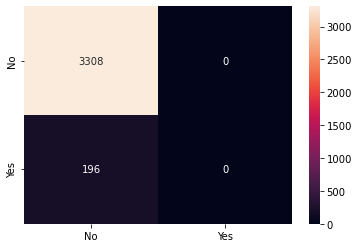

In [33]:
evaluate_model(data_nq, 'offer_accepted', regression_model, balance=None)

Model is predicting all offers as rejected and none as accepted. This is sigh of imbalanced data set.

We need to use SMOTE to balance data:

2. Logistic Regression + SMOTE

Rejected offers prediction accuracy: 68.68 %
Accepted offers prediction accuracy: 69.9 %


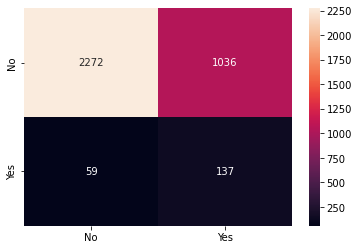

In [34]:
evaluate_model(data_nq, 'offer_accepted', regression_model, balance='smote')

With SMOTE model seems to perform similarly for both classes.

3. KNN Model 

In [35]:
KNN_model = KNeighborsClassifier(n_neighbors=3)

Rejected offers prediction accuracy: 98.28 %
Accepted offers prediction accuracy: 0.51 %


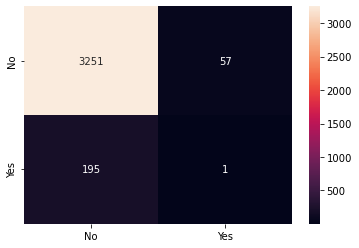

In [36]:
evaluate_model(data_nq, 'offer_accepted', KNN_model, balance=None)

4. KNN Model + SMOTE

Rejected offers prediction accuracy: 81.65 %
Accepted offers prediction accuracy: 29.08 %


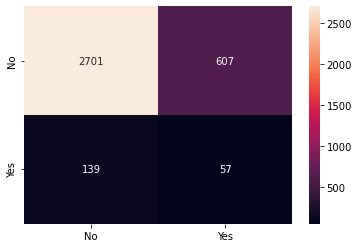

In [37]:
evaluate_model(data_nq, 'offer_accepted', KNN_model, balance='smote')

KNN model with SMOTE perform worse than Logistic regression and SMOTE

5. DTC

In [38]:
DTC =  DecisionTreeClassifier()

Rejected offers prediction accuracy: 93.38 %
Accepted offers prediction accuracy: 15.82 %


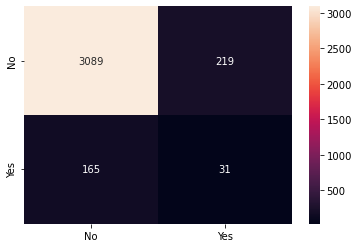

In [39]:
evaluate_model(data_nq, 'offer_accepted', DTC, balance=None)

6.DTC + SMOTE

Rejected offers prediction accuracy: 91.51 %
Accepted offers prediction accuracy: 16.84 %


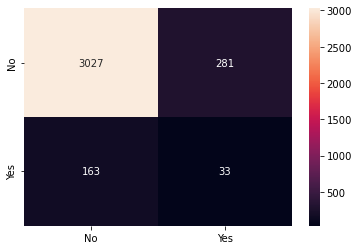

In [40]:
evaluate_model(data_nq, 'offer_accepted', DTC, balance='smote')

We will try to use data with non excluding quaterly balances and compare results:

In [42]:
data_2 = data.copy()


# 1. scale numerical data
num_norm_2 = normalize_data(data_2)

# 2. encode categorical data
cat_2 = encode_cat(data_2, 'offer_accepted')

# 3. concat 
data_wq = pd.concat([num_norm_2, cat_2], axis = 1)

1.Logistic Regression

Rejected offers prediction accuracy: 100.0 %
Accepted offers prediction accuracy: 0.0 %


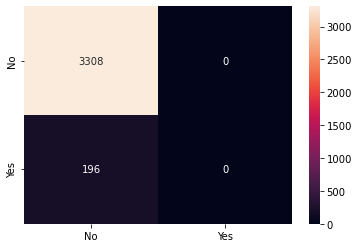

In [43]:
evaluate_model(data_wq, 'offer_accepted', regression_model, balance=None)

No difference in LogisticRegression without removing q balances.

2.Logistic Regression + SMOTE

Rejected offers prediction accuracy: 68.89 %
Accepted offers prediction accuracy: 69.9 %


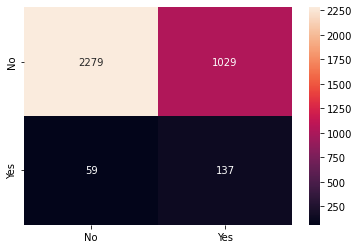

In [44]:
evaluate_model(data_wq, 'offer_accepted', regression_model, balance='smote')

3. KNN

Rejected offers prediction accuracy: 98.28 %
Accepted offers prediction accuracy: 0.51 %


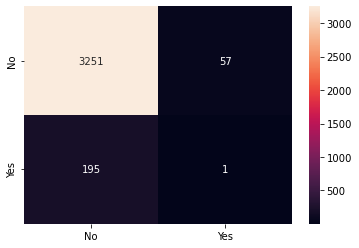

In [45]:
evaluate_model(data_wq, 'offer_accepted', KNN_model, balance=None)

4. KNN + SMOTE

Rejected offers prediction accuracy: 81.71 %
Accepted offers prediction accuracy: 30.1 %


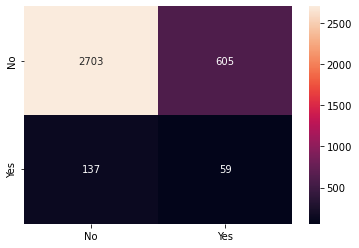

In [46]:
evaluate_model(data_wq, 'offer_accepted', KNN_model, balance='smote')

5. DTC 

Rejected offers prediction accuracy: 93.77 %
Accepted offers prediction accuracy: 14.29 %


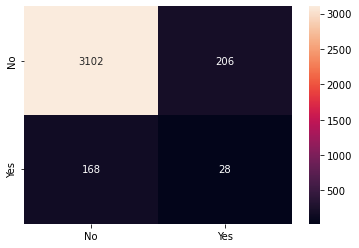

In [47]:
evaluate_model(data_wq, 'offer_accepted', DTC, balance=None)

Rejected offers prediction accuracy: 91.69 %
Accepted offers prediction accuracy: 15.31 %


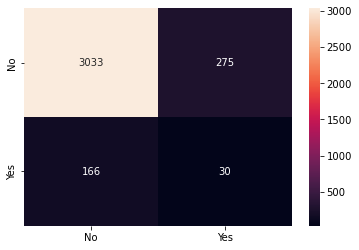

In [48]:
evaluate_model(data_wq, 'offer_accepted', DTC, balance='smote')

### The best model in terms of prediction accuracy across both accepted & rejected offers was logistic regression where the data was without balances for each quarter and training set was oversampled using SMOTE - 68.89% for rejected offers and 69.90% for accepted offers. Next steps would involve choosing different models  or explore different feature selections to improve the prediction accuracy.